In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny

# Preprocess Images

In [49]:
def applyThreshold(img, threshold = 0):
    return img * (img> threshold)

def loadImagesFromFolder(folder, threshold = 0):
    images = []
    file_names = []
    for file_name in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,file_name))
        if img is not None:
            images.append(applyThreshold(img, threshold=threshold))
            file_names.append(file_name)
    return np.array(images), np.array(file_names)



def showImg(img, file_name = "asd", figure_size = (5,5)):
    fig = plt.figure(figsize=figure_size)
    plt.imshow(img, cmap='gray')
    plt.title(file_name)
    
def getEdgeImg(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = canny(gray_img/255.).astype(np.uint8)
    return edge
def getDialateImg(img):
    edge = getEdgeImg(img)
    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(edge,kernel,iterations = 1)
    return dilation
def drawCircle(img, file_name = "asd", figure_size = (5,5)):
    img = getDialateImg(img)
    contours, hierarchy= cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    fig = plt.figure(figsize = figure_size)
    ax = fig.add_subplot()
    ax.imshow(img, cmap = 'gray')

    for i in contours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            circle = plt.Circle((cx, cy), 20, color='y', alpha=0.3)
            ax.add_artist(circle)
    ax.set_title(file_name)
def countObj(img):
    contours, hierarchy= cv2.findContours(getDialateImg(img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return len(contours)

In [56]:
folder_path = "../images/bayonne/"
images, file_names = loadImagesFromFolder(folder_path, threshold= 60)

date = np.array([file_name[:-4] for file_name in file_names])

32


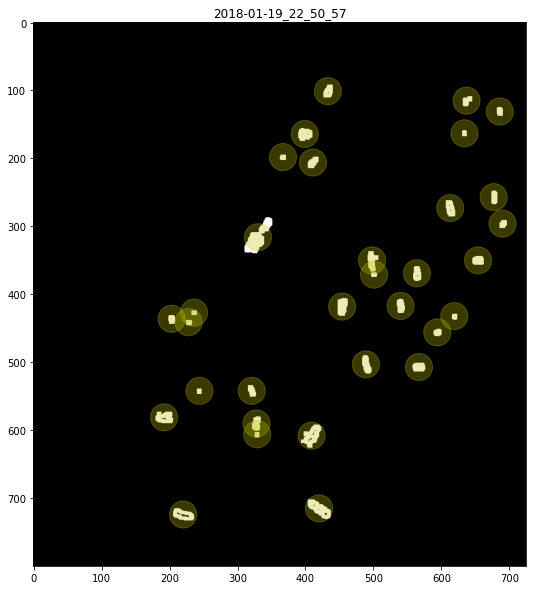

In [57]:
img_index = 1
# img_index = 90 # noisy day
img = images[img_index]

#show original image
showImg(img, date[img_index], figure_size = (10, 10))

#edge detection
showImg(getEdgeImg(img), date[img_index], figure_size = (10, 10))

#dialate image
showImg(getDialateImg(img), date[img_index], figure_size = (10, 10))

#count number of ship
drawCircle(img, date[img_index], figure_size = (10, 10))
print(countObj(img))

In [5]:
from celluloid import Camera
from tqdm import tqdm
def createGif(folder_path, gif_path):
    images, file_names = loadImagesFromFolder(folder_path, threshold= 0)
    date = np.array([file_name[:-4] for file_name in file_names])
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot()
    
    camera = Camera(fig)
    for i in tqdm(range(len(images))):
        ax.imshow(images[i], cmap='gray')
        # ax.set_title(date[i])
        ax.text(0.1, 0.9, date[i], color='white', ha='center', va='center', fontsize=20, transform=ax.transAxes)
        camera.snap()
        
        
    animation = camera.animate()
    animation.save(gif_path, writer='Pillow', dpi=100, fps=1)

        

In [6]:
# Create Gif

# folder_path = "../images/suez/"
# gif_path = "../gif/suez.gif"
# createGif(folder_path, gif_path)

In [7]:
# folder_path = "../images/longbeach/"
# gif_path = "../gif/longbeach.gif"
# createGif(folder_path, gif_path)

# Turning Images Into Tabular data

In [8]:
min_threshold = 20
max_threshold = 80

file_name ="bayonne"
folder_path = "../images/{}/".format(file_name)
images_min_threshold, file_names = loadImagesFromFolder(folder_path, threshold= min_threshold)
n_obj_min_threshold = np.array([countObj(img) for img in images_min_threshold])

date = np.array([file_name[:-4] for file_name in file_names])
images_max_threshold, file_names = loadImagesFromFolder(folder_path, threshold= max_threshold)
n_obj_max_threshold = np.array([countObj(img) for img in images_max_threshold])

In [32]:
min_threshold = 40
max_threshold = 80

folder_path = "../images/"

data = {}

dir_names = os.listdir(folder_path)
for dir_name in tqdm(dir_names):
    
    
    images_min_threshold, file_names = loadImagesFromFolder(folder_path + dir_name, threshold= min_threshold)
    n_obj_min_threshold = np.array([countObj(img) for img in images_min_threshold])
    
    images_max_threshold, file_names = loadImagesFromFolder(folder_path + dir_name, threshold= max_threshold)
    n_obj_max_threshold = np.array([countObj(img) for img in images_max_threshold])
    
    date = np.array([file_name[:-4] for file_name in file_names])
    # print(date)
    if len(date[0])>10:
        date = np.array([single_date[:10] for single_date in date])
        
    data[dir_name] = {}
    data[dir_name]["date"] = date
    data[dir_name]["max_boat"] = n_obj_min_threshold
    data[dir_name]["min_boat"] = n_obj_max_threshold

100%|██████████| 5/5 [01:00<00:00, 12.13s/it]


In [34]:
for dir_name in dir_names:
    print(data[dir_name]["date"][0])
    
for dir_name in dir_names:
    print(data[dir_name]["date"][-1])

2018-01-07
2018-01-04
2018-01-01
2018-01-06
2018-01-04
2021-12-29
2021-12-20
2021-12-23
2021-12-28
2021-12-26


In [114]:
start_date = "2018-01-07"
end_date = "2021-12-20"

dir_name = "bayonne"

In [134]:
dir_names[1]

'longbeach'

In [141]:
dir_name = 'longbeach'

df =pd.DataFrame({"time":data[dir_name]["date"], "n_obj_min_threshold":data[dir_name]["min_boat"], "n_obj_max_threshold":data[dir_name]["max_boat"]})
print(df.head())
df["time"] = pd.to_datetime(df["time"])
df.set_index('time')
df = df.set_index('time').resample('6D', origin = start_date).interpolate()

df.reset_index(inplace=True)
print(df.head())

mask = (df['time'] >= start_date) & (df['time'] <= end_date)
df.loc[mask]

min_boat,max_boat = df['n_obj_min_threshold'].to_numpy(), df['n_obj_max_threshold'].to_numpy()
date = df['time']
avg_boat = (min_boat + min_boat)/2
err_boat = np.maximum( np.abs(avg_boat - min_boat), np.abs(avg_boat - max_boat))

save_data = pd.DataFrame({"date":date, "y":avg_boat, "y_err":err_boat})
print(save_data.head())

out_dir = "../data/{}.csv".format(dir_name)
df.to_csv(out_dir)

         time  n_obj_min_threshold  n_obj_max_threshold
0  2018-01-04                   16                   17
1  2018-01-10                   19                   20
2  2018-01-16                   16                   17
3  2018-01-22                   11                   12
4  2018-01-28                   12                   13
        time  n_obj_min_threshold  n_obj_max_threshold
0 2018-01-01                  NaN                  NaN
1 2018-01-07                  NaN                  NaN
2 2018-01-13                  NaN                  NaN
3 2018-01-19                  NaN                  NaN
4 2018-01-25                  NaN                  NaN
        date   y  y_err
0 2018-01-01 NaN    NaN
1 2018-01-07 NaN    NaN
2 2018-01-13 NaN    NaN
3 2018-01-19 NaN    NaN
4 2018-01-25 NaN    NaN


In [147]:
data[dir_name]["date"][0]

'2018-01-04'

In [154]:
df =pd.DataFrame({"time":data[dir_name]["date"], "n_obj_min_threshold":data[dir_name]["min_boat"], "n_obj_max_threshold":data[dir_name]["max_boat"]})
print(df.head())
df["time"] = pd.to_datetime(df["time"])
df = df.set_index('time').resample('D', origin = 'start').interpolate()
print(df[:10])
df = df.resample('6D', origin=start_date).interpolate()
print(df.head())

         time  n_obj_min_threshold  n_obj_max_threshold
0  2018-01-04                   16                   17
1  2018-01-10                   19                   20
2  2018-01-16                   16                   17
3  2018-01-22                   11                   12
4  2018-01-28                   12                   13
            n_obj_min_threshold  n_obj_max_threshold
time                                                
2018-01-04                 16.0                 17.0
2018-01-05                 16.5                 17.5
2018-01-06                 17.0                 18.0
2018-01-07                 17.5                 18.5
2018-01-08                 18.0                 19.0
2018-01-09                 18.5                 19.5
2018-01-10                 19.0                 20.0
2018-01-11                 18.5                 19.5
2018-01-12                 18.0                 19.0
2018-01-13                 17.5                 18.5
            n_obj_min_thresh

In [163]:
# Use pandas to make plot prettier
import pandas as pd

for dir_name in dir_names:

    df =pd.DataFrame({"time":data[dir_name]["date"], "n_obj_min_threshold":data[dir_name]["min_boat"], "n_obj_max_threshold":data[dir_name]["max_boat"]})
    df["time"] = pd.to_datetime(df["time"])
    df.set_index('time')
    
    df = df.set_index('time').resample('D', origin = 'start').interpolate()
    df = df.resample('6D', origin = start_date).interpolate()

    df.reset_index(inplace=True)

    mask = (df['time'] >= start_date) & (df['time'] <= end_date)
    # print(mask)
    # print(df.head())
    df = df.loc[mask]
    # print(df.head())

    min_boat,max_boat = df['n_obj_min_threshold'].to_numpy(), df['n_obj_max_threshold'].to_numpy()
    date = df['time']
    
    avg_boat = (min_boat + min_boat)/2
    err_boat = np.maximum( np.abs(avg_boat - min_boat), np.abs(avg_boat - max_boat))

    save_data = pd.DataFrame({"date":date, "y":avg_boat, "y_err":err_boat})
    
    
    out_dir = "../data/{}.csv".format(dir_name)
    save_data.to_csv(out_dir)



In [162]:
out_dir

'../data/suez.csv'

In [166]:
a = 1
b =[]
b.append(a)
a = -1
b

[1]

In [165]:
save_data['date']

1     2018-01-07
2     2018-01-13
3     2018-01-19
4     2018-01-25
5     2018-01-31
         ...    
237   2021-11-23
238   2021-11-29
239   2021-12-05
240   2021-12-11
241   2021-12-17
Name: date, Length: 241, dtype: datetime64[ns]

Text(0.5, 1.0, 'n ships every 6 days')

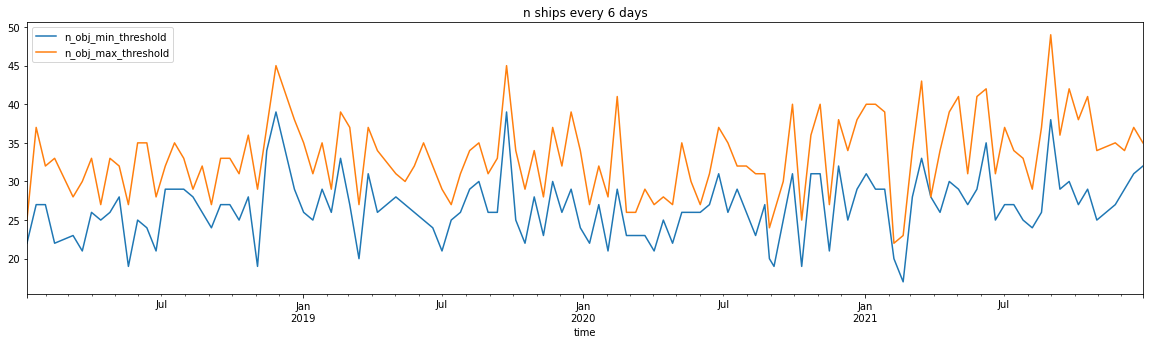

In [124]:
fig = plt.figure(figsize=(20, 5))
ax = fig.subplots()

df.plot(x = "time", y="n_obj_min_threshold", figsize = (20, 5), ax = ax)
df.plot(x = "time", y="n_obj_max_threshold", figsize = (20, 5), ax = ax)
ax.set_title("n ships every 6 days")

In [26]:
n_obj_avg = (n_obj_min_threshold + n_obj_max_threshold)/2
n_obj_err = np.maximum( np.abs(n_obj_avg - n_obj_min_threshold), np.abs(n_obj_avg - n_obj_max_threshold))
df["y"] = n_obj_avg
df["y_err"] = n_obj_err


In [27]:
# Use pandas to make plot prettier
import pandas as pd

df =pd.DataFrame({"time":date, "y":n_obj_avg, "y_err":n_obj_err})
df["time"] = pd.to_datetime(df["time"])

Text(0.5, 1.0, 'n ships every 6 days')

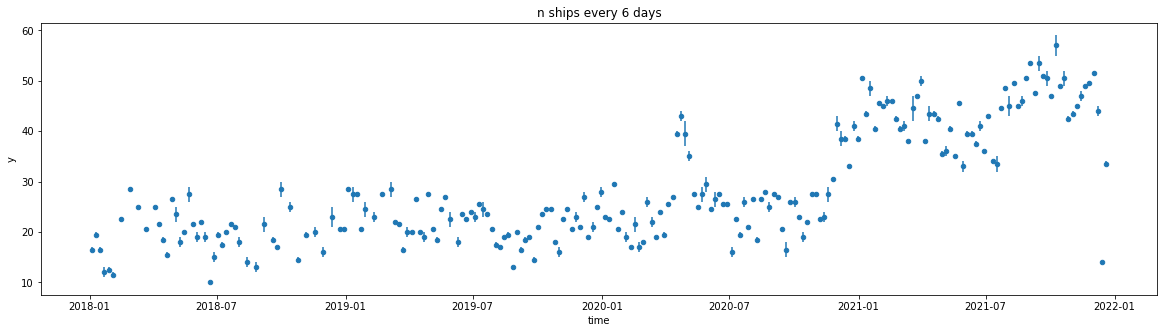

In [28]:
fig = plt.figure(figsize=(20, 5))
ax = fig.subplots()

df.plot(kind = "scatter", x = "time", y="y", yerr= "y_err", figsize = (20, 5), ax = ax)
ax.set_title("n ships every 6 days")

In [22]:
out_dir = "../data/{}.csv".format(file_name)
df.to_csv(out_dir)

Text(0.5, 1.0, 'n ships every 6 days')

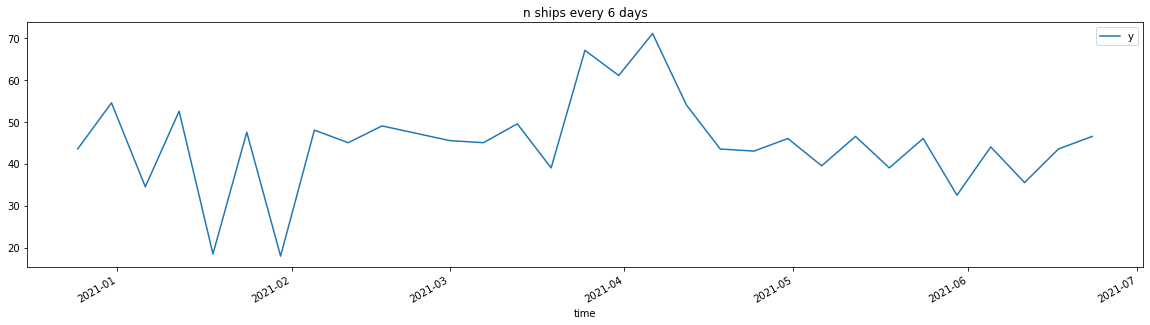

In [347]:
fig = plt.figure(figsize=(20, 5))
ax = fig.subplots()
df[180:210].plot(x = "time", y="y", figsize = (20, 5), ax = ax)
# df[150:250].plot(x = "time", y="y", figsize = (20, 5), ax = ax)
ax.set_title("n ships every 6 days")

# Testing part, dont mind these

<ErrorbarContainer object of 3 artists>

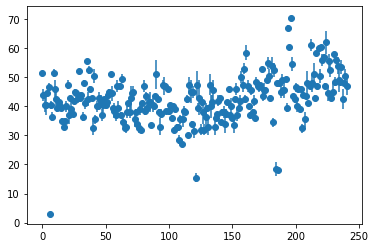

In [300]:
plt.errorbar(range(len(n_obj_avg)), n_obj_avg, yerr=n_obj_err, fmt='o')

In [195]:
n_obj = np.array(n_obj)
n_obj_threshold = np.array(n_obj_threshold)
np.sum(n_obj == n_obj_threshold)

27

In [183]:
np.sum(n_obj - n_obj_threshold)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

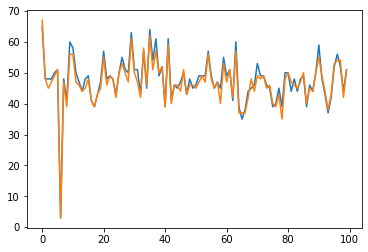

In [177]:
plt.plot(n_obj[:100])
plt.plot(n_obj_threshold[:100])

In [178]:
print(np.sum(n_obj == n_obj_threshold))

0


In [153]:
folder_path = "../images/suez/"
images, file_names = loadImagesFromFolder(folder_path, threshold= 0)

#convert to grayscale iamge
# images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

In [125]:
# edge detection with Canny
from skimage.feature import canny
edges = np.array([canny(img/255.) for img in images]).astype(np.uint8)

In [144]:
n_obj = np.array([countObj(img) for img in images])

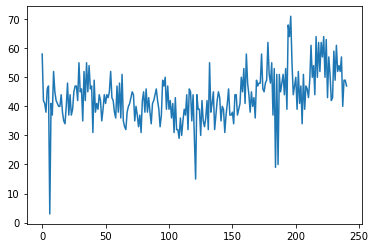

In [145]:
plt.plot(n_obj)

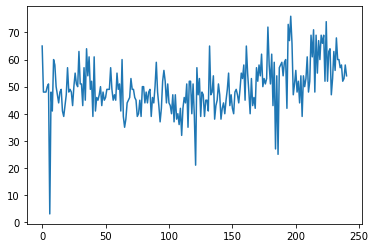

In [147]:
folder_path = "../images/suez/"
images, file_names = loadImagesFromFolder(folder_path, threshold= 0)
n_obj = np.array([countObj(img) for img in images])
plt.plot(n_obj)

#convert to grayscale iamge
# images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

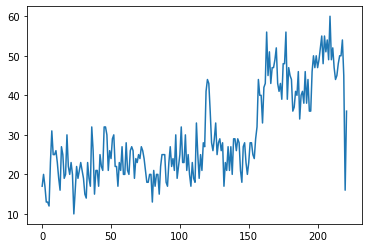

In [148]:
folder_path = "../images/longBeach/"
images, file_names = loadImagesFromFolder(folder_path, threshold= 0)
n_obj = np.array([countObj(img) for img in images])
plt.plot(n_obj)

#convert to grayscale iamge
# images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

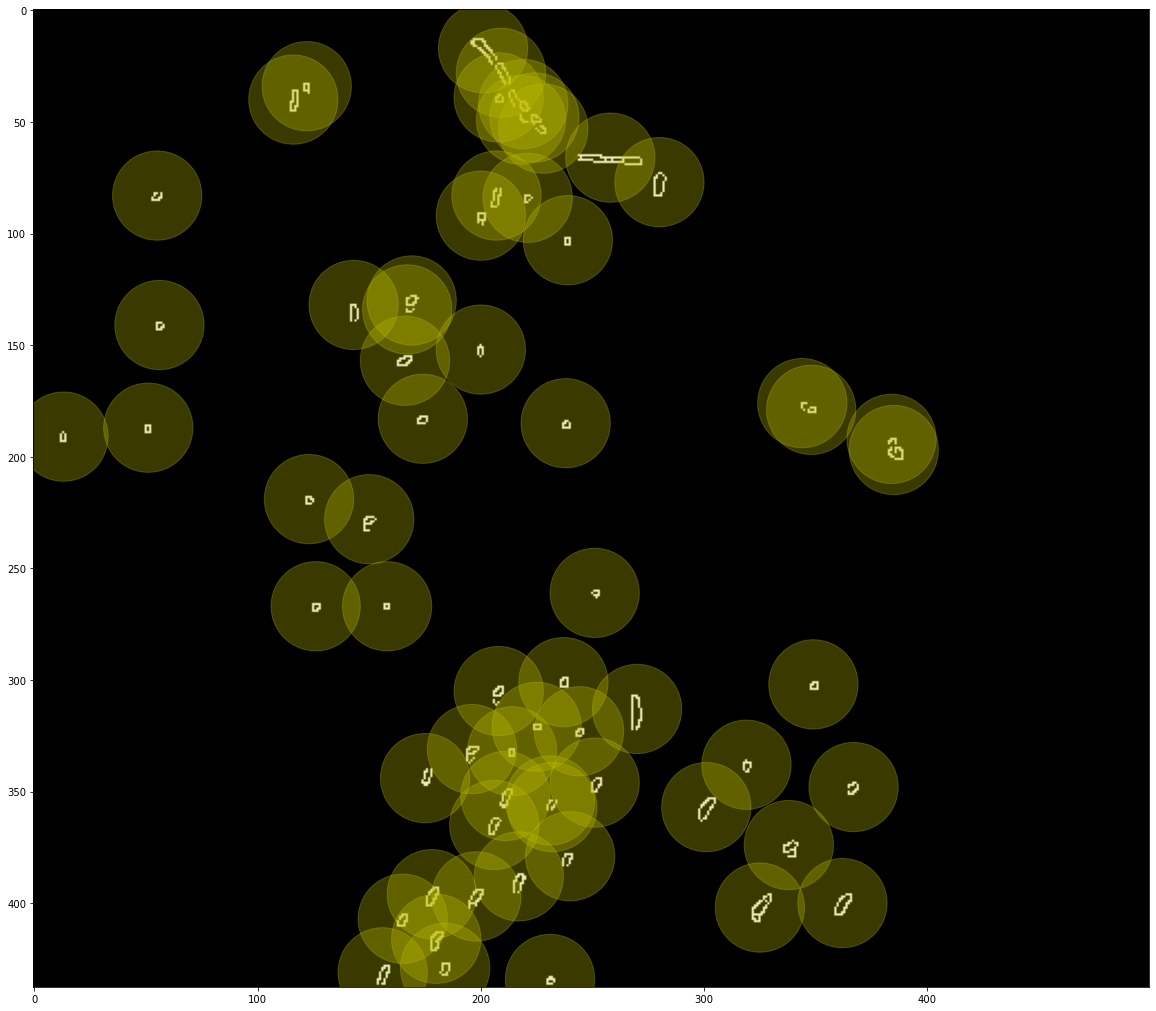

In [132]:
drawCircle(dilation[0])

In [58]:
circle = plt.Circle((x1, y1), agent_radius, color='y', alpha=0.3)

            ax_simulation.add_artist(circle)

232

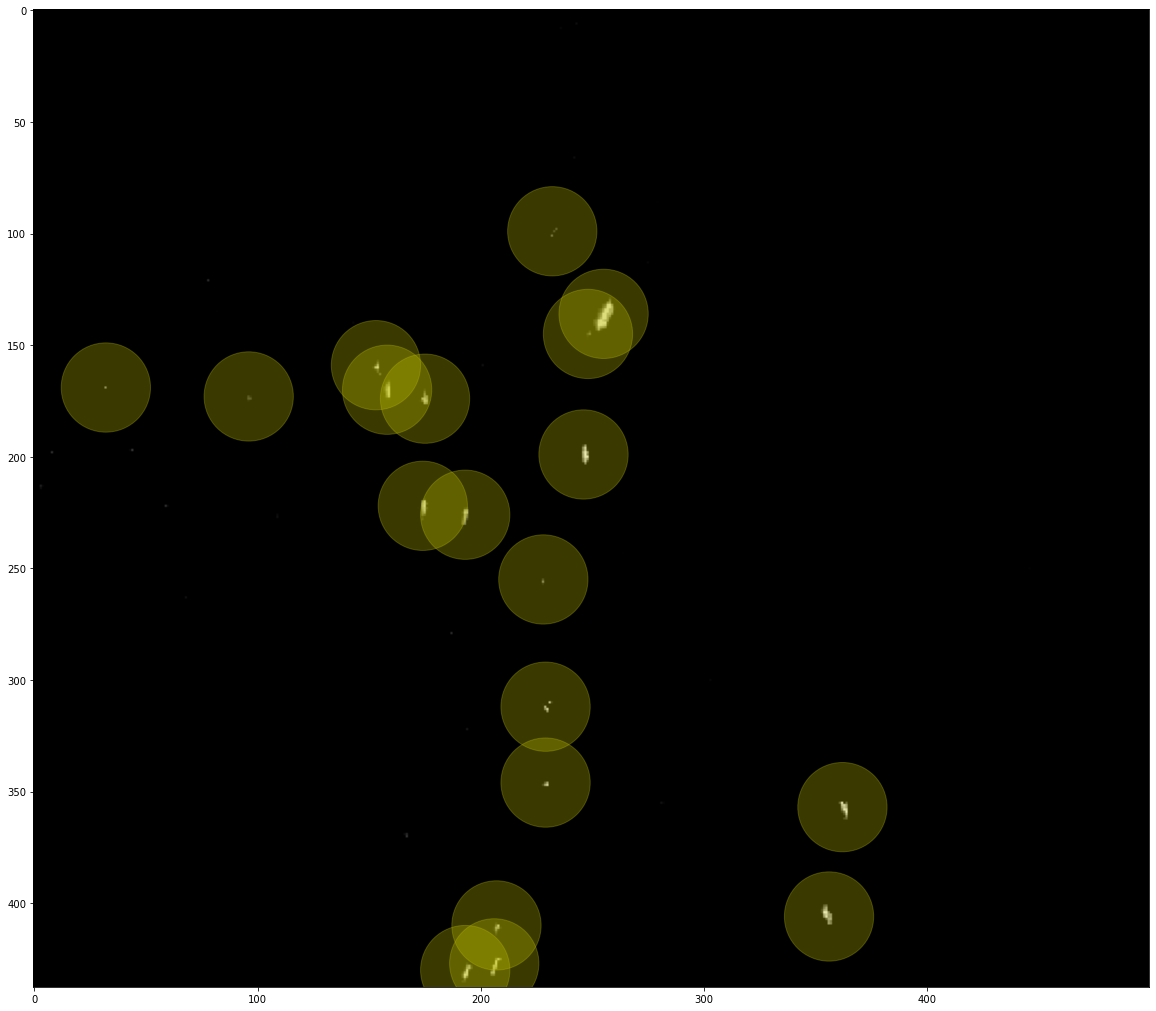

In [68]:
# kernel = np.ones((5,5),np.uint8)

image = images[1].copy()
edge = canny(image/255.).astype(np.uint8)
kernel = np.ones((1,1), np.uint8)
dilation = cv2.dilate(edge,kernel,iterations = 1)
contours, hierarchy= cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot()
ax.imshow(image, cmap = 'gray')

for i in contours:
    M = cv2.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        circle = plt.Circle((cx, cy), 20, color='y', alpha=0.3)
        ax.add_artist(circle)



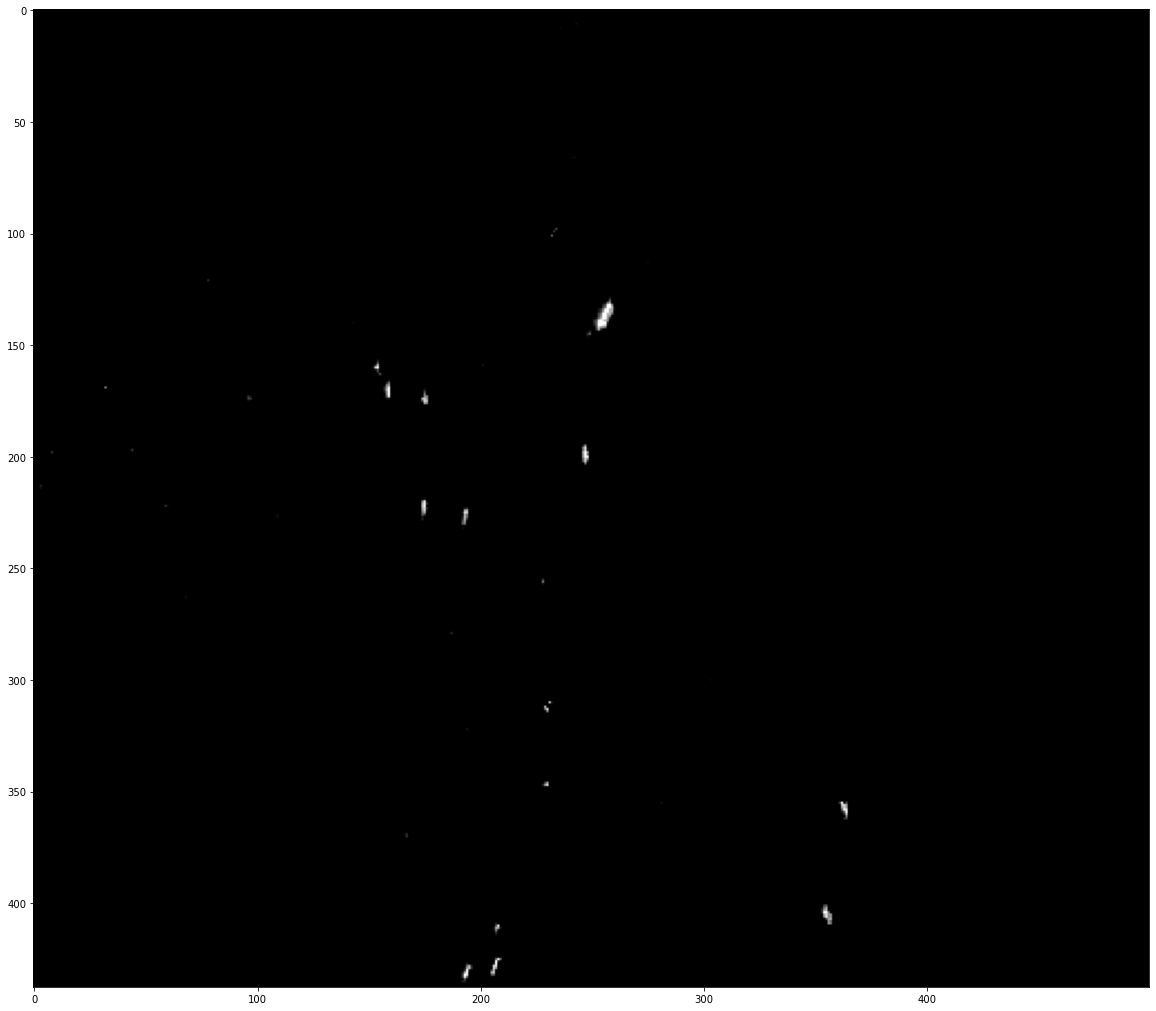

In [71]:
image = images[1].copy()
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot()
ax.imshow(image, cmap = 'gray')

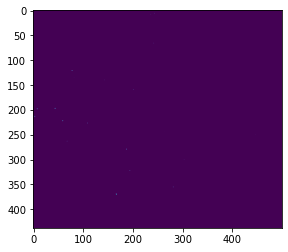

In [55]:
# kernel = np.ones((5,5),np.uint8)

image = images[1].copy()
edge = canny(image/255.).astype(np.uint8)
kernel = np.ones((1,1), np.uint8)
dilation = cv2.dilate(edge,kernel,iterations = 1)
contours, hierarchy= cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



for i in contours:
    M = cv2.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv2.drawContours(image, [i], -1, (0, 255, 0), 2)
        cv2.circle(image, (cx, cy), 20, (0, 0, 255), -1)
        cv2.putText(image, "center", (cx - 20, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

plt.imshow(image)

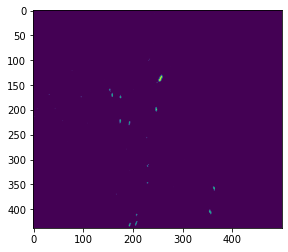

In [54]:
plt.imshow(images[1])

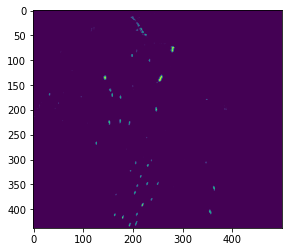

In [48]:
plt.imshow(images[1])

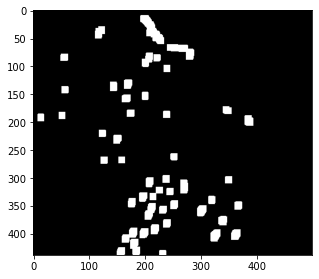

In [38]:
show_img(dilation)

In [28]:
contours, hierarchy= cv2.findContours(edges[0].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [183]:
a = [5, 4, 3, 2, 1]
a = [1, 2, 3, 4, 5]
k = 3

In [193]:
def quickSelect(left, right):
    
    pivot = left
    l, r = left, right
    if left>= right:
        return 0
    while l<r:
        while a[r]<=a[pivot] and l<r:
            r-=1
        while a[l]>=a[pivot] and l<r:
            l+=1
        
            
        if l<r:
            a[l], a[r] = a[r], a[l]
    a[l], a[pivot] = a[pivot], a[r]
    
    # quickSelect(l+1, right)
    # quickSelect(left, l-1)
        
    if l+1 == k:
        return a[:l+1]
    elif l+1<k:
        return quickSelect(l+1, right)
    else:
        return quickSelect(left, l-1)

In [194]:
a = [76, 68, 89, 31, 7, 1, 98, 42]
k =

quickSelect(0, len(a) - 1)
a

[5, 4, 3, 2, 1]

In [195]:
a = '1'
a.isdigit()

True

In [196]:
a = 3 # 011
b = 5 # 101

a^b # 110

6

In [198]:
a ^ 1<<1

1

In [ ]:
w1 = "leet"
w2 = "code"

for i in range(len(w1) + 1):
    if w1[-i:] == w2[:i] or i == 0:
        w2[i:]